This test file is an example of a script which uses the generic scattering calculator functionality.

The generic scattering calculator can create orientation averages for purely nuclear systems and ideally
a script should be able to recreate the same results - and extend the idea to magnetic systems.

The default sld data in the calculator describes a 60x60x60 angstrom cube of 10x10x10 pixels, each with
sld 6.97e-06 angstrom^-2. This fits very well in the fitting tool to a parallelepiped model.

This script intends to recreate this data using an average of multiple calculations

First of all make the required imports:

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.spatial.transform import Rotation

from sas.sascalc.calculator import sas_gen

Now we need to set some constants. We want to define the size of the sample - a cube with n pixels in each direction, and a fixed stepsize between each node, as well as the discretisation of rotation space.

In [2]:
STEPSIZE=6
NODES=10
ANGLESTEP = 10

We now define a function to create a discretised version of 3D rotation space.

3D rotation space can be defined by three parameters. If the rotation takes the cartesian basis
{x,y,z} to {x',y',z'} then we define the euler angles:

- $\phi$: a rotation about the z axis
- $\theta$: a rotation about the new y axis
- $\chi$: a rotation about the new z axis

That is to say that $\theta$ and $\phi$ define the direction of the z' axis in polar coordinates from the {x,y,z} basis, and $\chi$ 
defines the additional rotation about the z' axis of the x' and y' axes.

The discretised space is returned as a (N,4) numpy array with N elements and columns representing:

- 0: The $\theta$ value of the element
- 1: The $\phi$ value of the element
- 2: The $\chi$ value of the element
- 3: The relative weighting of the element (should sum to 1)

In [3]:
def create_rotation_grid(theta_step, phi_step, chi_step):
    # create spherical grid
    theta = np.linspace(0, 180, theta_step+1)
    phi = np.linspace(0, 360, phi_step+1)
    chi = np.linspace(0, 360, chi_step+1)
    # first index on theta, second on phi - use "ij"
    THETA, PHI, CHI = np.meshgrid(theta, phi, chi, indexing="ij")
    centre_theta = np.zeros((THETA.shape[0]-1, THETA.shape[1]-1, THETA.shape[2]-1))
    centre_phi = np.zeros((PHI.shape[0]-1, PHI.shape[1]-1, PHI.shape[2]-1))
    centre_chi = np.zeros((CHI.shape[0]-1, CHI.shape[1]-1, CHI.shape[2]-1))
    solid_angle = np.zeros((THETA.shape[0]-1, THETA.shape[1]-1, THETA.shape[2]-1))
    for i in range(THETA.shape[0]-1):
        for j in range(THETA.shape[1]-1):
            for k in range(THETA.shape[2]-1):
                centre_theta[i,j,k] = (THETA[i, j, k] + THETA[i+1,j, k])/2.0
                centre_phi[i,j,k] = (PHI[i, j, k] + PHI[i,j+1, k])/2.0
                centre_chi[i,j,k] = (CHI[i, j, k] + CHI[i,j, k+1])/2.0
                # solid angle = sin(theta)d(theta)d(phi)
                # chi is evenly distributed so don't include in relative weighting
                solid_angle[i,j, k] = math.sin(np.radians(centre_theta[i,j, k])) \
                                    *  np.radians(THETA[i+1, j, k] - THETA[i,j, k]) \
                                    *  np.radians(PHI[i, j+1, k] - PHI[i,j, k])
    return np.column_stack((centre_theta.flatten(), centre_phi.flatten(), \
                            centre_chi.flatten(), solid_angle.flatten()/(np.sum(solid_angle))))

We now define the range of Q values at which we want to calculate the average. Here we will choose 30 values from 0 to 0.3 (measured in per angstroms, the sasview default). We also create the data describing the sample, our discretisation of rotation space, and a numpy array to store the output

In [4]:
Qs = np.linspace(3e-4, 0.3, 30)
points = np.linspace(0, STEPSIZE*NODES, NODES, endpoint=False)
pos_x, pos_y, pos_z = np.meshgrid(points, points, points)
pos_x = pos_x.flatten()
pos_y = pos_y.flatten()
pos_z = pos_z.flatten()
data = sas_gen.MagSLD(pos_x, pos_y, pos_z, np.full_like(pos_x, 6.97e-06))
model = sas_gen.GenSAS()
model.set_sld_data(data)
angles = create_rotation_grid(ANGLESTEP, 2*ANGLESTEP, 2*ANGLESTEP)
output = np.zeros_like(Qs)

We can now carry out the actual averaging. We loop over the rotation space and sum together the weighted instensities in each orientation. We take the Q values along the $Q_x$ axis each time. As the sample is rotated this axis stays fixed in beamline coordinates - and so it sweeps through all the orientations of the sample.

In [5]:
# for printing progress - the next fraction of completeness at which to print
next_frac = 0.01
for i in range(len(angles)):
    r = Rotation.from_euler("ZYZ", [np.radians(angles[i, 1]), np.radians(angles[i, 0]), np.radians(angles[i, 2])])
    model.set_rotations(xyz_to_UVW=r)
    # weights already normalised no need to divide by sum of weights
    output += model.runXY([Qs, np.zeros_like(Qs)]) * angles[i, 3]
    if i/len(angles) >= next_frac:
        print(f"{next_frac*100: .1f}%")
        next_frac += 0.01
clear_output()

Because our sample is grid type data - with only a nuclear SLD, we can also use the inbuilt debye full average function - and compare the results

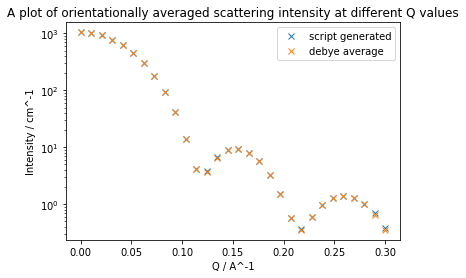

In [6]:
model.set_rotations() # reset to identity
debye_output = model.run([Qs, []])
plt.plot(Qs, output, "x", label="script generated")
plt.plot(Qs, debye_output, "x", label="debye average")
plt.xlabel("Q / A^-1")
plt.ylabel("Intensity / cm^-1")
plt.yscale("log")
plt.title("A plot of orientationally averaged scattering intensity at different Q values")
plt.legend()
plt.show()

In fact a comparison with the analytical result from the fitting calculator in Sasview would show that both of these results differ signifcantly from the correct value at higher Q values on the graph. This is because the cube has only been discretised in a 10x10x10 grid in real space. by changing the initial paramters to give a better discretisation for the same shape, such as:

In [7]:
NODES = 20
STEPSIZE = 3

We would create a significantly more accurate result.